## Image Search Series Part IV: Advancing Wound Care with Foundation Models and Context-Aware Retrieval ## 

This tutorial demonstrates how to build an **Image Search System** using **MedImageInsight (MI2)** with embedding-based retrieval and **vision-language model (VLM)**–based context-aware reasoning. 

#### Data 
This tutorial uses the **WoundcareVQA dataset** for Wound Care Visual Question Answering. 

🔗 The WoundcareVQA dataset can be downloaded from: [WoundcareVQA Dataset](https://osf.io/xsj5u/).

The dataset includes a training set (used to create the index for the image search system) and a test set (used for evaluation). Pre-computed MedImageInsight embeddings of the training and test images are also provided to facilitate replication. 

- **Training Split** — `dataset-full-original/images_train.zip` (retrieval database).
- **Testing Split** — `dataset-full-original/images_test.zip` (query set).
- **Annotation File** — `dataset-full-original/woundcarevqa.json` (labels). 
- **Embeddings** — `MedImageInsight-embeddings` (train/test embeddings and FAISS index).  


We focus on the **Infection Detection** task with three labels: infected, not infected, and unclear.   

#### Online Endpoint Deployment
The **MedImageInsight (MI2) Model** is available for deployment through the **[Azure AI Model Catalog](https://azure.microsoft.com/en-us/products/ai-model-catalog)**, providing a straightforward way to access and use the model.

For those preferring a programmatic approach, detailed instructions can be found in the dedicated **[deployment notebook](https://aka.ms/healthcare-ai-examples-mi2-deploy)**. This guide outlines the steps required to deploy the MI2 model efficiently via code.


#### Environment
1. Install the **healthcareai_toolkit** package from the root of the repository:
   ```sh
      pip install ./package
   ```
2. Set up your `.env` file with the `DATA_ROOT` and `MI2_MODEL_ENDPOINT` parameters.
3. The toolkit depends on **FAISS**. It will be installed automatically.  
   If needed, you can also install it manually with:
   ```sh
      pip install faiss-cpu
   ```

##### FAISS (Facebook AI Similarity Search)
[FAISS](https://github.com/facebookresearch/faiss) provides efficient algorithms for searching large sets of vectors, even those too large to fit in memory. It supports adding or removing individual vectors and computes exact distances between them.


#### Embedding-based Retrieval & VLM–based Context-aware Reasoning 

This tutorial demonstrates how to retrieve similar wound images using an embedding model and the FAISS library, and then, following a **Retrieval-Augmented Generation (RAG)** approach, leverage the retrieved examples to ground and support vision-language model (VLM) reasoning for classification. 

#### 🔍 How Does It Work?
- Generating embeddings (vector representations) for wound images.
- Building a FAISS index to store these embeddings.
- Querying the FAISS index with a new image embedding to retrieve the most similar images.
- Using retrieved examples as input to a VLM for example-augmented classification. 

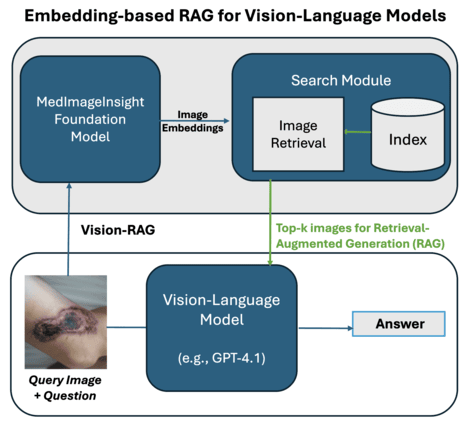


## 🚀 Steps in this Tutorial

1. **Setup and Data Preparation**
   - Authenticate with **AzureML** and load the online **MI2** client.
   - Download the WoundcareVQA dataset (train/test images and annotations).

2. **Compute Embeddings**
   - Generate **MedImageInsight (MI2)** embeddings for wound images via the MI2 REST API endpoint, or use the provided pre-computed embeddings.

3. **Create a Search System**
     - Build a FAISS index from the MI2 embeddings of the training set for efficient similarity search.
     
4. **Retrieve Top-k Similar Images and Their Labels for a Given Test Image/Query**
   - Query the FAISS index with test image embeddings to retrieve visually similar training images and their associated labels.
5. **Vision–Language Model (e.g., GPT-4.1)**
   - Use a VLM to integrate retrieved examples into a prompt for few-shot reasoning.

6. **Retrieval-Augmented Image Classification with Vision-Language Models**
   - Classify the target test image by providing retrieved images with labels as in-context examples to the VLM.

7. **Evaluation of Model Predictions against Ground Truth Labels**
   - Compare predicted infection labels with ground truth annotations to compute accuracy. 

8. **Organize, Save, and Visualize Model Predictions vs. Ground Truth**
   - Save predictions and visualize selected examples with their predicted and true labels. 
      


In [1]:
import os
import numpy as np
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt
from PIL import Image
from collections import OrderedDict, Counter
import SimpleITK as sitk
from openai import AzureOpenAI
from openai import OpenAIError
import time
import base64

# Suppress SimpleITK warnings
sitk.ProcessObject_SetGlobalWarningDisplay(False)

/anaconda/envs/azureml_py38/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


### Data Paths

Download the data files as described above and update the data paths below to match your environment.

In [2]:
from healthcareai_toolkit.clients import MedImageInsightClient
from healthcareai_toolkit.search.search_backbone import (
    medical_image_search,
    generate_index,
)

base_dir = ""

## Load image input folder for generating image embeddings
test_input_folder = f"{base_dir}/images_test"
train_input_folder = f"{base_dir}/images_train"
## Load json file with labels and splits
json_file = f"{base_dir}/woundcarevqa.json"

## Embedding Folders
train_embd_dir = f"{base_dir}/woundcare_train_embeddings"
test_embd_dir = f"{base_dir}/woundcare_test_embeddings"

## Index Files
index_folder = f"{base_dir}/woundcare_index"
## create new files
train_index = index_folder + "/faiss_index_embd_train.index"
train_index_tsv = index_folder + "/faiss_ids_embd_train.tsv"

language = "en"  ## zh or en

# Selected Examples
k = 5

## Results file
results_csv_file = f"{base_dir}/mi2_rag5_gpt4.1_infection_classification.csv"

In [3]:
# Images and associated labels
with open(json_file, encoding="utf-8") as f:
    qa_data = json.load(f)

print(qa_data[0].keys())
print(len(qa_data), "instances")

image_list = []
label_list = []
for post in qa_data:
    woundT = post.get("infection")
    images = post.get("image_ids", [])
    patient_question = (
        post.get(f"query_title_{language}", "")
        + " "
        + post.get(f"query_content_{language}", "")
    )
    for img in images:
        image_list.append(img)
        label_list.append(woundT)

img_dict = {"image_id": image_list, "infection": label_list}
img_df = pd.DataFrame(img_dict)

# Display the DataFrame without truncation
with pd.option_context("display.max_colwidth", None):
    print(img_df)

dict_keys(['src', 'post_id', 'post_url', 'anatomic_locations', 'wound_type', 'wound_thickness', 'tissue_color', 'drainage_amount', 'drainage_type', 'infection', 'query_title_en', 'query_title_zh', 'query_content_en', 'query_content_zh', 'responses', 'split', 'images_original', 'encounter_id', 'image_ids'])
477 instances
                  image_id     infection
0     IMG_ENC0001_0001.jpg      infected
1     IMG_ENC0001_0002.jpg      infected
2     IMG_ENC0001_0003.jpg      infected
3     IMG_ENC0002_0001.jpg  not_infected
4     IMG_ENC0002_0002.jpg  not_infected
..                     ...           ...
743  IMG_ENC0476_0002.jpeg  not_infected
744  IMG_ENC0278_0001.jpeg      infected
745  IMG_ENC0477_0001.jpeg  not_infected
746  IMG_ENC0279_0001.jpeg  not_infected
747  IMG_ENC0279_0002.jpeg  not_infected

[748 rows x 2 columns]


In [4]:
def get_image_lists_from_json(json_file):
    """
    Load train/test image lists from the dataset JSON file.
    Parameters:
        json_file (str): Path to the JSON file.

    Returns:
        tuple: (train_image_list, test_image_list)
    """
    with open(json_file, "r", encoding="utf-8") as f:
        data = json.load(f)

    train_image_list, test_image_list = [], []

    for item in data:
        split = item.get("split", "").lower()
        image_ids = item.get("image_ids", [])

        if split == "train":
            train_image_list.extend(image_ids)
        elif split == "test":
            test_image_list.extend(image_ids)

    return train_image_list, test_image_list


train_image_list, test_image_list = get_image_lists_from_json(json_file)

print("Train:", len(train_image_list), "images")
print("Test:", len(test_image_list), "images")

Train: 449 images
Test: 152 images


### 2. Embedding Generation
We use the [MedImageInsight](https://arxiv.org/abs/2410.06542) (MI2) foundation model for generating embeddings from medical images.

In [5]:
# Connect to MI2 Endpoint
submit = True
if submit:
    mi2_client = MedImageInsightClient()
    submitter = mi2_client.create_submitter(n_jobs=2, return_as="list")

Using ml_client base_url 1: https://management.azure.com
Using ml_client base_url 2: https://management.azure.com


In [6]:
def get_file_list(folder_path):
    file_list = [
        f
        for f in os.listdir(folder_path)
        if f.lower().endswith((".jpg", ".jpeg"))
        and os.path.isfile(os.path.join(folder_path, f))
    ]
    return file_list


test_image_list = get_file_list(test_input_folder)
train_image_list = get_file_list(train_input_folder)


def generate_image_embeddings(
    submitter, input_dir, subj_list, output_embd_dir, save_feature=False
):
    """
     Generate image embeddings for a list of subjects using the MI2 submitter.

    Parameters:
        submitter (object): MI2 submitter instance.
        input_dir (str): Directory containing input images.
        subj_list (list[str]): Filenames of subject images.
        output_embd_dir (str): Directory to save embeddings if `save_feature=True`.
        save_feature (bool): Whether to save embeddings as .pkl files.

    Returns:
        (np.ndarray, list[str]): Embeddings array and corresponding subject list.
    """

    image_files = [os.path.join(input_dir, subj) for subj in subj_list]
    _, image_features_list = submitter.submit(
        image_list=image_files, total=len(image_files)
    )
    features = [np.array(item["image_features"]) for item in image_features_list]
    features = np.array(features)

    if features.ndim == 3 and features.shape[1] == 1:
        features = features.squeeze(1)
    elif features.ndim == 3 and features.shape[2] == 1:
        features = features.squeeze(2)

    print(f"Features shape after reshape: {features.shape}")

    if save_feature:
        os.makedirs(output_embd_dir, exist_ok=True)
        if len(subj_list) != len(features):
            print(
                f"Warning: Mismatch between subjects ({len(subj_list)}) and features ({len(features)})"
            )

        for subj, emb in zip(subj_list, features):
            subj_name = os.path.splitext(subj)[0]
            output_image_pkl = os.path.join(
                output_embd_dir, f"{subj_name}_mi2_embedding.pkl"
            )

            with open(output_image_pkl, "wb") as f:
                pickle.dump(emb, f)

            print(f"Saved Image Feature as pkl file for Subject: {subj_name}")

    return features, subj_list


## Test Set Embeddings
if len(os.listdir(test_embd_dir)) == 0:
    test_image_features = generate_image_embeddings(
        submitter, test_input_folder, test_image_list, test_embd_dir, save_feature=True
    )

## Training Set Embeddings
if len(os.listdir(train_embd_dir)) == 0:
    train_image_features = generate_image_embeddings(
        submitter,
        train_input_folder,
        train_image_list,
        train_embd_dir,
        save_feature=True,
    )

### 3. Create a Search System
#### Building the FAISS Index

FAISS enables efficient similarity search by indexing vectors. When using **flat vectors**, FAISS stores each vector exactly and performs **exact nearest neighbor search** by comparing all vectors using a distance metric, such as **Euclidean distance**.

In this approach, vectors are stored in a **flat index** (`IndexFlatL2`), ensuring high precision by searching all vectors in memory. This method is ideal for smaller datasets, where search speed is less of a concern. While the flat index guarantees accurate results, it can be slower for large datasets due to the exhaustive comparison of each vector.

For larger datasets, other indexing methods like **HNSW (Hierarchical Navigable Small World)** and **IVFPQ (Inverted File with Product Quantization)** can be used to approximate searches, improving speed while balancing precision. See more on [FAISS documentation pages](https://github.com/facebookresearch/faiss/wiki/Guidelines-to-choose-an-index). 


In [7]:
## Build Index
if not os.path.exists(train_index) or not os.path.exists(train_index_tsv):
    ## Embeddings of the training set
    train_embs_list = []
    for img in train_image_list:
        img_emb = os.path.join(
            train_embd_dir, img[: img.index(".")] + "_mi2_embedding.pkl"
        )
        train_embs_list.append(img_emb)
    if not os.path.exists(index_folder):
        os.makedirs(index_folder)

    ## Generate FAISS index
    d = 1024
    generate_index(train_embs_list, d, train_index, train_index_tsv)

else:
    print("Index available.")

# Search Engine
search_engine = medical_image_search(ids_path=train_index_tsv, index_path=train_index)

Index available.


### 4. Retrieve top-k similar images and their labels for a given test image/query

In [8]:
search_results = {"query_img": [], "results": []}
df_results = pd.DataFrame(search_results)
for img in test_image_list:
    query_img_id = img[: img.index(".")]
    test_volume_emb_path = os.path.join(
        test_embd_dir, query_img_id + "_mi2_embedding.pkl"
    )
    search_results["query_img"].append(query_img_id)
    D, Res = search_engine.perform_search(query=test_volume_emb_path, k=k)
    results = [str(x).split("_mi2")[0] for x in Res[0][0]]
    resultswoDup = list(OrderedDict.fromkeys(results))
    if len(resultswoDup) > k:
        resultswoDup = resultswoDup[:k]
    search_results["results"].append(resultswoDup)
df_results = pd.DataFrame(search_results)
df_results


def get_infection_label(topID, img_df):
    """
    Retrieve infection label for a given image ID.

    Parameters:
        topID (str or int): Image ID (or filename prefix) to match.
        img_df (pd.DataFrame): Must contain 'image_id' and 'infection' columns.
    Returns:
        list[str] or None: Infection label(s) if a match is found,
        otherwise None.
    """

    topID = str(topID)
    result = img_df[
        img_df["image_id"].str.startswith(topID)
        & img_df["image_id"].str.endswith((".jpg", ".jpeg"))
    ]
    if not result.empty:
        return result["infection"].iloc[0]
    else:
        return None


def get_topk_images_labels_maj_vote(query_img, df_results, train_input_folder, img_df):
    """
    Find training images for a query image and filter them by majority label.

    Parameters:
    query_img (str): Query image filename.
    df_results (pandas.DataFrame): Must contain 'query_img' (str) and 'results' (list of IDs).
    train_input_folder (str): Path to folder containing training images.
    img_df (pandas.DataFrame): Maps image IDs to infection labels.

    Returns:
    list of (str, list of str): Tuples of (image_path, labels). Empty list if no matches.
    """

    query_img = os.path.splitext(query_img)[0]
    df_results["query_img"] = df_results["query_img"].astype(str).str.strip()
    result_row = df_results[df_results["query_img"] == query_img]
    if result_row.empty:
        print(f"No results found for query image: {query_img}")
        return []
    result_ids = result_row["results"].iloc[0]
    all_examples = []
    all_labels = []

    def find_image_file(res_id, folder):
        for ext in [".jpg", ".jpeg"]:
            path = os.path.join(folder, res_id + ext)
            if os.path.isfile(path):
                return path
        return None

    for res_id in result_ids:
        label_list = get_infection_label(res_id, img_df)
        if label_list:
            image_path = find_image_file(res_id, train_input_folder)
            if image_path:
                all_examples.append((image_path, label_list))
                all_labels.extend(label_list)

    if not all_labels:
        return []

    # Determine majority label across all label lists
    label_counts = Counter(all_labels)
    majority_label = label_counts.most_common(1)[0][0]

    # Keep only examples where the majority label is in their label list
    filtered_examples = [
        (path, labels) for (path, labels) in all_examples if majority_label in labels
    ]
    return filtered_examples

### 5. Vision-Language Model (e.g., GPT-4.1)

In [ ]:
endpoint = ""  ## Add Endpoint URL
model_name = "gpt-4.1"
deployment = "gpt-4.1"

api_key = ""  ## Add your key
api_version = "2025-01-01-preview"

client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=endpoint,
    api_key=api_key,
)

 ### 6. Retrieval-Augmented Image Classification with Vision-Language Models

 We propose an example-augmented few-shot classification approach for wound infection detection. For each query image, visually similar cases are retrieved via embedding-based search and paired with their labels. These examples are encoded as in-context demonstrations for a vision-language model, which then predicts the infection status of the query image from a constrained label set (infected, not_infected, unclear).

In [10]:
def encode_image(image_path):
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def classify_image_with_examples(target_image_path, example_images_labels):
    """
    Classify a target medical image using few-shot visual examples retrieved via embedding-based search.

    Parameters:
    target_image_path : str
        Path to the image to classify.
    example_images_labels : list[tuple[str, str | list[str]]]
        Few-shot examples as (image_path, label) or (image_path, list_of_labels).

    Returns: str | None
        Predicted class name: one of {"infected", "not infected", "unclear"}.
        Returns None if the API call fails.
    """

    # System message with instructions
    prompt = [
        {
            "role": "system",
            "content": """Instructions: You are a skilled medical doctor reviewing medical images sent by patients. 
        Classify the wound shown in the image into one of these classes. Respond with the exact class name only without additional explanation or details. 

         Classes = [
                "infected",
                "not infected",
                "unclear",
            ]
                """,
        }
    ]

    # Add examples
    for image_path, label in example_images_labels:
        base64_img = encode_image(image_path)
        prompt.append(
            {
                "role": "user",
                "content": [
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{base64_img}"},
                    },
                    {"type": "text", "text": f"Answer: [{label}]"},
                ],
            }
        )

    # Add target image without a label
    target_base64 = encode_image(target_image_path)
    prompt.append(
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {"url": f"data:image/jpeg;base64,{target_base64}"},
                }
            ],
        }
    )

    try:
        response = client.chat.completions.create(
            messages=prompt, max_tokens=20, temperature=0, top_p=1.0, model=deployment
        )
        output = response.choices[0].message.content
        print("## Output: ", output)
        return output
    except OpenAIError as e:
        print("Prompt was blocked or failed:", str(e))
        return None


model_predictions = []

for image in os.listdir(test_input_folder):
    image_path = os.path.join(test_input_folder, image)
    if image_path.lower().endswith((".jpg", ".jpeg")):
        print(f"Processing image: {image}")
        ## Top-k images and their labels
        example_images_labels = get_topk_images_labels_maj_vote(
            image, df_results, train_input_folder, img_df
        )
        ## Classify image with k examples
        model_pred = classify_image_with_examples(image_path, example_images_labels)
        time.sleep(10)
        model_predictions.append(model_pred)
print("Done")

Processing image: IMG_ENC0385_0001.jpg
## Output:  not_infected
Processing image: IMG_ENC0386_0001.jpg
## Output:  unclear
Processing image: IMG_ENC0387_0001.jpg
## Output:  not_infected
Processing image: IMG_ENC0388_0001.jpg
## Output:  unclear
Processing image: IMG_ENC0389_0001.jpg
## Output:  infected
Processing image: IMG_ENC0390_0001.jpg
## Output:  infected
Processing image: IMG_ENC0391_0001.jpg
## Output:  not infected
Processing image: IMG_ENC0392_0001.jpg
## Output:  unclear
Processing image: IMG_ENC0393_0001.jpg
## Output:  [unclear]
Processing image: IMG_ENC0394_0001.jpg
## Output:  [unclear]
Processing image: IMG_ENC0395_0001.jpg
## Output:  [not_infected]
Processing image: IMG_ENC0396_0001.jpg
## Output:  [infected]
Processing image: IMG_ENC0397_0001.jpg
## Output:  unclear
Processing image: IMG_ENC0397_0002.jpg
## Output:  not infected
Processing image: IMG_ENC0398_0001.jpg
## Output:  infected
Processing image: IMG_ENC0398_0002.jpg
## Output:  infected
Processing image: 

 ### 7. Evaluation of Model Predictions against Ground Truth Labels

In [11]:
# Generate dictionary to organize all probabilities corresponding to image_id
pred_dict = {
    image_id: {
        "pred_text": pred_label.replace("[", "")
        .replace("]", "")
        .replace("not infected", "not_infected")
    }
    for image_id, pred_label in zip(test_image_list, model_predictions)
}

# Extract ground truth labels and categories
gt_dict = {
    image_id: {
        "label": img_df[img_df["image_id"] == image_id]["infection"].values[0],
    }
    for image_id in test_image_list
}

# Compare predictions with ground truth and log unexpected predictions
all_gt_labels = set(img_df["infection"].unique())

unexpected_labels = list(
    {
        pred["pred_text"]
        for pred in pred_dict.values()
        if pred["pred_text"] not in all_gt_labels
    }
)

print("Unexpected labels:", unexpected_labels)

# Compute accuracy between pred_dict and gt_dict
accuracy = sum(
    all(pred in gt_dict[image_id]["label"] for pred in pred_dict[image_id]["pred_text"])
    for image_id in test_image_list
) / len(test_image_list)

print("Classification Accuracy:", accuracy)

Unexpected labels: []
Classification Accuracy: 0.7697368421052632


### 8. Organize, Save, and Visualize Model Predictions vs. Ground Truth

prediction:  infected
gt:  infected
prediction:  unclear
gt:  unclear
prediction:  not_infected
gt:  not_infected
prediction:  infected
gt:  not_infected


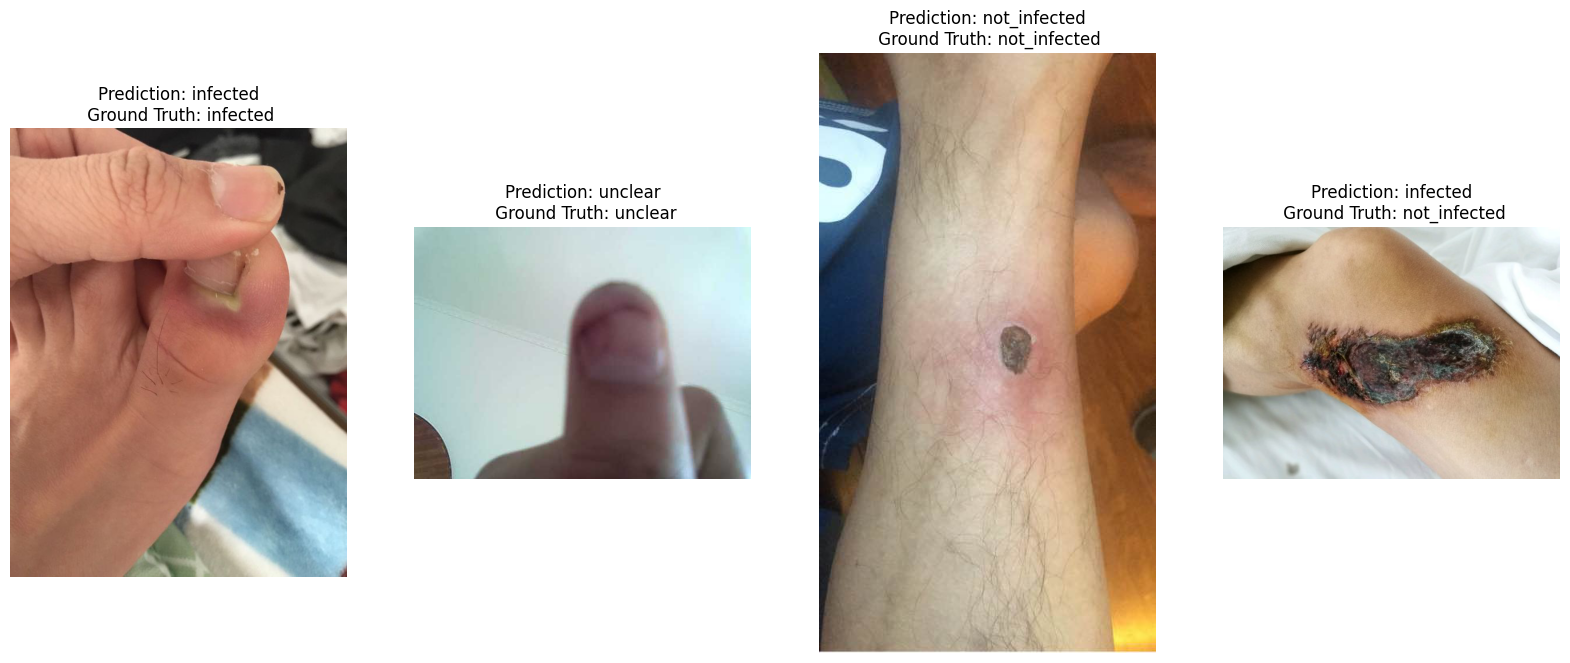

In [13]:
## Organize and save the results for sample selection and visualization

df = pd.DataFrame(
    {
        "image_id": test_image_list,
        "prediction_label": [
            pred_dict[image_id]["pred_text"] for image_id in test_image_list
        ],
        "ground_truth_label": [
            gt_dict[image_id]["label"] for image_id in test_image_list
        ],
    }
)

df.to_csv(results_csv_file, index=False)


# Select four images to visualize
selected_images = [
    "IMG_ENC0399_0002.jpg",
    "IMG_ENC0386_0001.jpg",
    "IMG_ENC0409_0001.jpg",
    "IMG_ENC0414_0003.jpg",
]

selected_data = {
    image: {
        "selected_pred": df.loc[df["image_id"] == image, "prediction_label"].values[0],
        "selected_ground_truth_labels": df.loc[
            df["image_id"] == image, "ground_truth_label"
        ].values[0],
    }
    for image in selected_images
}

fig, axs = plt.subplots(1, 4, figsize=(20, 10))
for i, image_name in enumerate(selected_images):
    prediction = selected_data[image_name]["selected_pred"]
    print("prediction: ", prediction)
    gt = selected_data[image_name]["selected_ground_truth_labels"]
    print("gt: ", gt)
    image_path = os.path.join(test_input_folder, image_name)
    if image_name.endswith(".dcm"):
        reader = sitk.ImageFileReader()
        reader.SetFileName(image_path)
        image = sitk.GetArrayFromImage(reader.Execute())[0, :, :]
    elif image_name.endswith(".jpg"):
        image = Image.open(image_path)
    axs[i].imshow(image, cmap="bone")
    axs[i].axis("off")
    axs[i].set_title("Prediction: {}\n Ground Truth: {}".format(prediction, gt))

plt.show()

## Conclusion

##### In this notebook, we combined **embedding-based image retrieval** with **few-shot classification** in a RAG-style approach using a **VLM** to evaluate wound infection status from patient images. Predictions were compared against ground truth infection labels from the WoundcareVQA test set.
##### 
##### The combined method achieved an accuracy of **0.7697**. Notably, enriching VLM-based reasoning with visually similar retrieved cases outperformed both standalone embedding search and direct GPT prompting (cf. **[blog post](https://techcommunity.microsoft.com/blog/healthcareandlifesciencesblog/image-search-series-part-4-advancing-wound-care-with-foundation-models-and-conte/4456340)** for additional results). 
##### These findings suggest that infection assessment often relies on contextual or clinical cues that may not be fully captured by visual similarity alone but can be more effectively interpreted when supported by example-based reasoning over **retrieved cases and their associated labels**.  
